### Visualize 2D obstacle in joint space
To see if it is possible to predict or estimate the changes of the boundary of the moving obstacle in joint space
setup a 2D scenario for it. Apply a circle movement for the obstacle and plot the boundary in joint space.

In [1]:
import numpy as np
import time
import torch

import sys
sys.path.append('../')
from NN_model.nn_model_eval import NN_hand_obj

%load_ext autoreload
%autoreload 2


In [2]:
# generate data for the movement of the obstacle and grids for two joints

g = [1] # index finger

use_cuda = True
nn = NN_hand_obj(g=g, path_prefix_suffix=['../NN_model/models/single_', '01.pt'], use_cuda=use_cuda)

lb = nn.hand_bound[0, (g[0] - 1) * 4 + 1:g[0] * 4]
ub = nn.hand_bound[1, (g[0] - 1) * 4 + 1:g[0] * 4]

nums = 100

x_ = np.linspace(lb[0], ub[0], nums)
y_ = np.linspace(lb[1], ub[1], nums)

x, y= np.meshgrid(x_, y_, )

x1 = x.flatten().reshape(-1, 1)
y1 = y.flatten().reshape(-1, 1)

q = np.concatenate([np.zeros([nums ** 2, 1]), x1, y1, np.zeros([nums ** 2, 1])], axis=1)
q_gpu = torch.Tensor(q).to('cuda:0') if use_cuda else torch.Tensor(q)
print('Generate joint grid samples done!')

num_obj = 5
num_obj_move = 100
# x0 = np.array([[0.07, 0.044, 0.2]])
x0 = np.array([[0.07, 0.044, 0.17]])
x_obj = np.repeat(x0, num_obj, axis=0)

x_obj[:, 1] = np.linspace(0.04, 0.06, num_obj)
# x_obj = x_obj[..., np.newaxis]
x_obj_3D = np.zeros(x_obj.shape + (num_obj_move,))
x_obj_3D[:,1,:] = x0[0,1]
# let x_obj to move by circle in xoz plane.
x_radius = 0.01 * 1.5
for i in range(num_obj_move):
    theta_tmp = np.pi * 2 /  num_obj_move * i
    x_obj_3D[:,[0,2],i] =  np.array([[x0[0,0] + x_radius + x_radius * np.cos(theta_tmp), x0[0,2] + x_radius * np.sin(theta_tmp)]])


x_obj_3D_gpu = torch.Tensor(x_obj_3D).to('cuda:0') if use_cuda else torch.Tensor(x_obj_3D)

Hand-obj collision: load NN model from ../NN_model/models/single_101.pt use_cuda= True
Generate joint grid samples done!


In [3]:
x_obj_3D_gpu[:,:,0]

tensor([[0.1000, 0.0440, 0.1700],
        [0.1000, 0.0440, 0.1700],
        [0.1000, 0.0440, 0.1700],
        [0.1000, 0.0440, 0.1700],
        [0.1000, 0.0440, 0.1700]], device='cuda:0')

In [4]:
tuple(lb)

(-0.2969127672976807, -0.2740118722415367, -0.32753605719833834)

In [5]:
x_obj_3D_gpu.shape

torch.Size([5, 3, 100])

In [6]:
dis_= nn.eval_multiple(q_gpu, x_obj_3D_gpu[:,:,0], real_dis=True, only_min_dis=True, gradient=False)

In [7]:
dis_.shape

(10000,)

In [8]:
# %timeit output, grad = nn.eval(q_gpu[i,:], x_obj_gpu[j,:],real_dis=True, only_min_dis=True, gradient=True)

In [9]:
# use the sum of distance to calculate gradient
n = q.shape[0]

t0 = time.time()

dis_real_3D = np.zeros([nums**2, num_obj_move])
grad_real_3D = np.zeros([nums**2, 4, num_obj_move])
for j in range(num_obj_move):  # for each timestep of the obstacle
    dis2 = np.zeros([n, num_obj])
    grad2_ = []
    for i in range(num_obj):  # for each position of the obstacle
        dis_, grad_ = nn.eval_multiple(q_gpu[0:n], x_obj_3D_gpu[i:i+1,:,j], real_dis=True, only_min_dis=True, gradient=True)
        dis2[:,i] = dis_.flatten()
        grad2_.append(grad_)

    index_min = np.argmin(dis2, 1)
    dis2 = dis2[range(0,dis2.shape[0]),index_min] # only use the min distance
    # grad2 = np.asarray(grad2)
    grad2 = np.zeros([n,4])
    for i in range(n):
        grad2[i,:] = grad2_[index_min[i]][i,:]

    
    dis_real_3D[:,j] = dis2
    grad_real_3D[:,:,j] = grad2

t1 = time.time() - t0

print('time cost:', t1)

time cost: 2.5860822200775146


In [10]:
# This is for getting the unnormalized distance, which is used for isoline visualization
n = q.shape[0]
dis_unnor_3D = np.zeros([nums**2, num_obj_move])

for j in range(num_obj_move):  # for each timestep of the obstacle

    dis1 = np.zeros([n, num_obj])
    # dis_unnor_3D = np.zeros([nums**2, num_obj_move])
    for i in range(num_obj):
        dis_, _ = nn.eval_multiple(q_gpu[0:n], x_obj_3D_gpu[i:i+1,:,j], real_dis=False, only_min_dis=True, gradient=True)
        dis1[:,i] = dis_.flatten()

    index_min = np.argmin(dis1, 1)
    dis1 = dis1[range(0,dis2.shape[0]),index_min]
    dis_unnor_3D[:,j] = dis1


In [11]:
def vel_once(q_, dis, grad_):
    dq = ds_0.eval(q_)
    gamma = (dis - safety_margin) * dis_scale + 1
    M = modify_DS.get_M(grad_, gamma, rho=1)
    dq = M @ dq
    return dq[1:3]


In [12]:
q_now = np.array([0, 0.2752, 0.7089,0])
q_goal = np.array([0, 1.5, 1, 0])

In [13]:
grad_real_3D.shape

(10000, 4, 100)

In [14]:
q.shape

(10000, 4)

In [15]:
from DS import linear_system, Modulation
import tqdm

ds_0 = linear_system(q_goal)
modify_DS = Modulation(4)

safety_margin = 0.001  # meter
dis_scale = 100
rho = 1
# vel = np.zeros([dis2.shape[0], 2])


# for i in range(q.shape[0]):  # This can be acclerated by multiple processing
# # for i in range(1):
#     dq = ds_0.eval(q[i,:])
#     gamma = (dis2[i] - safety_margin) * dis_scale + 1
#     M = modify_DS.get_M(grad2[i,:], gamma, rho=5)
#     dq = M @ dq
#     vel[i,:] = dq[1:3]

def vel(j):  # single loop of multiple processing
    dq_all = np.zeros([nums**2, 2])
    for i in range(nums**2):

        dq = ds_0.eval(q[i,:])
        gamma = (dis_real_3D[i,j] - safety_margin) * dis_scale + 1
        M = modify_DS.get_M(grad_real_3D[i,:,j], gamma, dq=dq, rho=rho)
        dq = M @ dq
        dq_all[i,:] = dq[1:3]    
    return dq_all


# def vel(m):
#     i = m // num_obj_move  # for each joint
#     j = m % num_obj_move   # for each obj position
#     # dq_all = np.zeros([nums**2, 2])
#     # for i in range(nums**2):

#     dq = ds_0.eval(q[i,:])
#     gamma = (dis_real_3D[i,j] - safety_margin) * dis_scale + 1
#     M = modify_DS.get_M(grad_real_3D[i,:,j], gamma, dq=dq, rho=rho)
#     dq = M @ dq
#     return dq[1:3]

def cal_vel(num): # use multiple processing to speed it up
    from multiprocessing import Pool
    from contextlib import closing
    # Memory usage keep growing with Python's multiprocessing.pool
    # use this to close them
    # with Pool(40) as a_pool:
    with closing(Pool(10)) as a_pool: # use 10, in case out of memory
        result = list(tqdm.tqdm(a_pool.imap(vel, range(num)), total= num))

    # result = np.vstack(result)  # a list of array to array
    return result

# vel_3D = cal_vel(nums**2 * num_obj_move)
vel_3D = cal_vel(num_obj_move)

# from IPython.display import clear_output

# vel_3D = np.zeros([q.shape[0], 2, num_obj_move])
# for j in range(num_obj_move):  # todo, use double index with tqdm to speed it up, this will take 5 mins
#     print('timestep:', j)
#     vel_tmp = cal_vel(q.shape[0])
#     vel_3D[:,:,j] = vel_tmp

#     clear_output(wait=True)

100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


In [16]:
vel_3D[0].shape

(10000, 2)

In [17]:
len(vel_3D)

100

KeyboardInterrupt: 

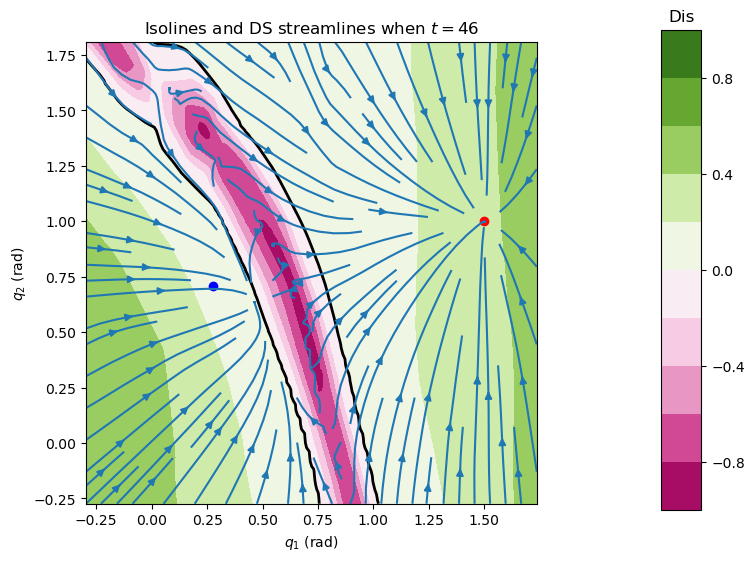

In [19]:
import matplotlib.pyplot as plt

level = np.linspace(-1,1,11)
import os
suffix = str(safety_margin)
path = 'figures/isoline_moving_obj_circle_' + suffix + '_rho_' + str(rho) + '_tail' + '_goal2'
os.makedirs(path+ '/', exist_ok=True)

for j in range(num_obj_move): # will be out of memory
# for j in range(1):
    fig, ax = plt.subplots(figsize=(8, 6))

    output = dis_unnor_3D[:,j].reshape(nums, nums) # use the distances without normalization
    vel_z = vel_3D[j].reshape(nums, nums, 2)

    con = plt.contourf(x, y, output, level, cmap='PiYG')

    plt.contour(con, levels=[0], colors=('k',),linestyles=('-',),linewidths=(2,))  # boundary of the obs in C space
    plt.title(label='Isolines and DS streamlines when $t=$' + str(j) )
    cax = plt.axes([0.95, 0.1, 0.05, 0.8])
    plt.colorbar(con, cax=cax)
    plt.title(label='Dis' )
    ax.scatter(q_now[1], q_now[2], c = 'b')
    ax.scatter(q_goal[1], q_goal[2], c = 'r')
    
    ax.streamplot(x[:,:], y[:,:], vel_z[:,:,0], vel_z[:,:,1], density=[1, 1]) # screamlines for DS in 2D
    ax.set_xlabel('$q_1$'+' (rad)')
    ax.set_ylabel('$q_2$'+' (rad)')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(nn.hand_bound[:,1])
    ax.set_ylim(nn.hand_bound[:,2])

    
    fig.savefig(path +'/' + str(j) + '.png',format='png',bbox_inches='tight',  pad_inches=0.0,dpi=300)
    plt.close()

In [4]:
# import gc
# gc.collect()

21

In [ ]:
# offset = 15
# nbGrid = 30
# x_grid_ = np.linspace(0,10, nbGrid)
# y_grid_ = np.linspace(-10,0, nbGrid)
# x_grid, y_grid = np.meshgrid(x_grid_, y_grid_)
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.streamplot(x_grid.T, y_grid, np.ones([nbGrid, nbGrid]), np.ones([nbGrid, nbGrid]), density=[1, 1])